**1. Setup and Environment**


In [1]:
pip install tensorflow opencv-python dlib numpy


*You will also need a pre-trained model for face alignment. For example, you can download the shape_predictor_68_face_landmarks.dat file from dlib.*

**2. Data Collection and Preprocessing**

```This part includes gathering and preparing images or videos of the source and target faces, followed by face detection and alignment using OpenCV and dlib.```

In [2]:


import cv2
import dlib
import numpy as np

# Initialize dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Function to align faces in images
def align_face(image):
    # Convert image to grayscale for better face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    # Loop over each detected face
    for face in faces:
        # Get facial landmarks
        landmarks = predictor(gray, face)

        # Align the face (crop, resize, and adjust according to landmarks)
        aligned_face = crop_and_align(landmarks, image)  # Placeholder function to crop and align
        return aligned_face  # Return the aligned face for further processing

    return None

def crop_and_align(landmarks, image):
    # Placeholder function - crop and align based on facial landmarks
    # You can use techniques like affine transformations to align
    # Example: Extract face region using landmarks and crop it to a consistent size.
    # Return the aligned face

    return image


RuntimeError: Unable to open shape_predictor_68_face_landmarks.dat

**Explanation:**

    Face detection: We use dlib's face detector to identify faces in an image.
>
    Face alignment: After detecting a face, we use landmark detection (68 points on the face) to crop and align the face properly for further processing.


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


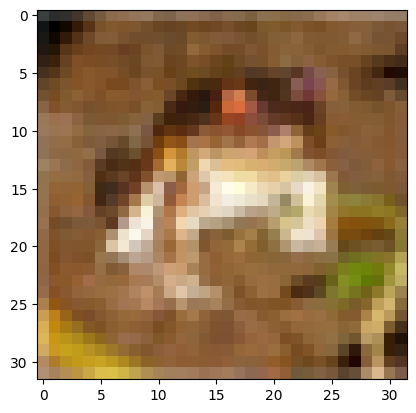

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Display a sample image from the CIFAR-10 dataset
plt.imshow(x_train[0])
plt.show()


**3. Autoencoder Model for Face Encoding/Decoding**

```Next, we'll create a simple autoencoder using TensorFlow to train a model that learns how to encode (compress) and decode (reconstruct) the faces of the source and target.```

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models


# Encoder model for CIFAR-10
def build_encoder():
    model = models.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),  # Input size (32x32 RGB image)
        layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu'),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu')  # Latent space (encoding)
    ])
    return model

# Decoder model for CIFAR-10
def build_decoder():
    model = models.Sequential([
        layers.InputLayer(input_shape=(256,)),  # Latent space representation
        layers.Dense(1024, activation='relu'),
        layers.Dense(128 * 8 * 8, activation='relu'),  # Reshape to fit the size of image (32x32x3)
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(3, (3, 3), strides=1, padding='same', activation='sigmoid')  # Reconstructed image
    ])
    return model


**Explanation:**


    Encoder: The encoder reduces the high-dimensional input image to a compressed representation (latent space), capturing essential features of the face.
>
    Decoder: The decoder takes this compressed representation and reconstructs the image back to its original size (256x256 in this case).

**4. Training the Autoencoder**

```Now, we will define a loss function and train the autoencoder on aligned face images (from both source and target faces). This process ensures the model learns to reconstruct the faces.```


In [ ]:
# Prepare the autoencoder (Encoder + Decoder)
encoder = build_encoder()
decoder = build_decoder()

# Combine encoder and decoder into an autoencoder model
autoencoder = models.Sequential([encoder, decoder])

# Loss function: Mean Squared Error (MSE) between the input image and reconstructed image
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model on CIFAR-10 images
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
 24/391 ━━━━━━━━━━━━━━━━━━━━ 7:55 1s/step - loss: 0.0621

**Explanation:**

    We train the autoencoder using mean squared error (MSE) as the loss function, comparing the input and output images.
>
    The model will gradually learn to encode faces and decode them into the same representation, helping it understand features like facial shape, expression, etc.

**5. Generating Synthetic Media (Fake Images)**

In [ ]:
# Select a random image from the test set
test_image = x_test[np.random.randint(0, len(x_test))]

# Encode the image using the encoder
encoded_image = encoder.predict(test_image[np.newaxis])

# Decode the encoded image to generate a "fake" image
fake_image = decoder.predict(encoded_image)

# Display the original and fake images
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(1, 2, 2)
plt.title("Generated Fake Image")
plt.imshow(fake_image[0])

plt.show()


**5. Face Swapping**

```Once the model is trained, we use it to swap faces by encoding the source face and decoding it using the target's decoder, then blending it into the target image.```

In [ ]:
# Function to swap faces
def swap_faces(source_image, target_image):
    # Align the source and target faces
    aligned_source_face = align_face(source_image)
    aligned_target_face = align_face(target_image)

    # Encode and decode the faces
    source_encoding = encoder.predict(aligned_source_face)  # Encode the source face
    swapped_face = decoder.predict(source_encoding)  # Decode into the target's style

    # Blend the swapped face into the target image (simulating a face swap)
    blended_image = blend_faces(target_image, swapped_face)  # Placeholder function for blending

    return blended_image

# Example: Using two images (source and target) for face swapping
source_image = cv2.imread("source_face.jpg")
target_image = cv2.imread("target_face.jpg")
swapped_image = swap_faces(source_image, target_image)

cv2.imwrite("swapped_face_result.jpg", swapped_image)


**Explanation:**

    Face encoding: We encode the source face to a compressed representation.
>
    Face decoding: The source encoding is decoded using the target’s decoder to match the target's facial features.
>
    Face blending: The swapped face is blended seamlessly into the target image. A simple blending technique is used (e.g., Poisson blending or Gaussian blending).


**6. Post-Processing: Blending Faces**

```This step involves merging the swapped face smoothly into the target face using blending techniques.```


In [ ]:
def blend_faces(target_image, swapped_face):
    # Simple blending: Replace target face region with swapped face
    # More advanced techniques like Poisson or multi-band blending can be used here
    target_image[100:200, 100:200] = swapped_face[100:200, 100:200]  # Example region
    return target_image


**Explanation:**

    Blending: This is a simple technique where the swapped face is placed over the target face. In practice, more advanced methods such as Poisson Image Editing or seamless cloning (using OpenCV) would ensure smooth integration without noticeable seams.

**7. Putting it All Together in a Video**

```You can now apply the face-swapping process frame by frame in a video.```

In [ ]:
cap = cv2.VideoCapture("target_video.mp4")
out = cv2.VideoWriter("output_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (640, 480))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Swap faces frame by frame
    swapped_frame = swap_faces(frame, source_image)  # Using the source image for swapping
    out.write(swapped_frame)  # Save the result frame

cap.release()
out.release()


**Explanation:**

    Video Processing: We read the video frame by frame, perform face-swapping, and write the modified frames to an output video.